In [1]:
import tensorflow as tf
import numpy as np
import os,pathlib

In [2]:
#方法定义 

def preprocess_data(dataset):
    all_images = []
    all_labels = []
    for image,label in dataset:
        preprocessed_image = tf.keras.applications.xception.preprocess_input(image)
        all_images.append(preprocessed_image)
        all_labels.append(label)
    return np.concatenate(all_images),np.concatenate(all_labels)

def get_r_list():
    index_r_list = []
    name_r_list = []
    for i,layer in enumerate(base_model.layers):
        if layer.name[0:3] == 'add':
            index_r_list.append(i)
            name_r_list.append(layer.name)
    index_r_list = index_r_list[::2]
    name_r_list = name_r_list[::2]
    r_list = [0]
    for i in index_r_list:
        r = i/len(base_model.layers)
        r_list.append(r)
    return r_list

def build_model():
    x = conv_base.output
    predictions = classifier(x)
    model = tf.keras.Model(inputs=conv_base.input,outputs=predictions)
    return model

def r_compiled_model():
    model = build_model()
    for layer in model.layers[:int(r*len(conv_base.layers))+1]:
        layer.trainable = False
    for layer in model.layers[int(r*len(conv_base.layers))+1:]:
        layer.trainable = True
        if isinstance(layer,tf.keras.layers.BatchNormalization):
            layer.trainable = False
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.9),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [3]:
#加载数据、预处理数据

base_dir = pathlib.Path('chest_xray2/label')
train_dataset = tf.keras.utils.image_dataset_from_directory(base_dir/'train',
                                                            image_size=(224,224),
                                                            batch_size=32)
validation_dataset = tf.keras.utils.image_dataset_from_directory(base_dir/'val',
                                                                 image_size=(224,224),
                                                                 batch_size=32)
train_images,train_labels = preprocess_data(train_dataset)
val_images,val_labels = preprocess_data(validation_dataset)

Found 100 files belonging to 2 classes.
Found 160 files belonging to 2 classes.


In [4]:
#分类器初训练

base_model = tf.keras.applications.xception.Xception(weights='imagenet',include_top=False)

inputs = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
x = tf.keras.layers.Dense(units=256,activation='relu')(x)
outputs = tf.keras.layers.Dense(units=1,activation='sigmoid')(x)
classifier_model = tf.keras.Model(inputs=inputs,outputs=outputs)

x = base_model.output
predictions = classifier_model(x)
model = tf.keras.Model(inputs=base_model.input,outputs=predictions)

for layer in model.layers[:len(base_model.layers)]:
    layer.trainable = False
    
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
callback_list = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2),
                 tf.keras.callbacks.ModelCheckpoint(filepath='xception_r_1.00.keras',
                                                    monitor='val_accuracy',
                                                    save_best_only=True)]
history = model.fit(train_images,train_labels,
                    epochs=15,
                    validation_data=(val_images,val_labels),
                    callbacks=callback_list)
r_1_acc = max(history.history['val_accuracy'])
print(r_1_acc)

Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - ETA: 0s - loss: 1.7681 - accuracy: 0.5500WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000024E65BEF620> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

In [5]:
#搜索最佳迁移率R(验证理论)

classifier_p = model.get_layer(model.layers[-1].name)
r_list = get_r_list()
best_acc = r_1_acc
r_acc = []

for i in range(len(r_list)):
    r = r_list[i]
    conv_base = tf.keras.applications.xception.Xception(weights='imagenet',include_top=False)
    classifier = classifier_p
    model = r_compiled_model()
    filepath = 'xception_r_{:.2f}.keras'.format(r)
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2),
                 tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                    monitor='val_accuracy',
                                                    save_best_only=True)]
    history = model.fit(train_images,train_labels,
                        epochs=15,
                        validation_data=(val_images,val_labels),
                        callbacks=callbacks)
    r_acc.append(max(history.history['val_accuracy']))
    
    if i == 0 and r_acc[0] < r_1_acc:
        r_list = r_list[:1]+r_list[:0:-1]
        continue
    if r_acc[i] > best_acc:
        best_acc = r_acc[i]

Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - ETA: 0s - loss: 0.1528 - accuracy: 0.9600WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000024E04608620> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

4/4 [==============================] - ETA: 0s - loss: 0.1498 - accuracy: 0.9500WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000024E04646950> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - 26s 7s/step - loss: 0.1498 - accuracy: 0.9500 - val_loss: 0.1823 - val_accuracy: 0.9438
Epoch 2/15
4/4 [==

4/4 [==============================] - 18s 5s/step - loss: 0.1471 - accuracy: 0.9600 - val_loss: 0.1803 - val_accuracy: 0.9438
Epoch 2/15
4/4 [==============================] - 16s 5s/step - loss: 0.1456 - accuracy: 0.9700 - val_loss: 0.1769 - val_accuracy: 0.9438
Epoch 3/15
4/4 [==============================] - 16s 4s/step - loss: 0.1440 - accuracy: 0.9700 - val_loss: 0.1754 - val_accuracy: 0.9438


In [6]:
#观察结果

print(r_list)
print(r_acc)

[0, 0.11363636363636363, 0.26515151515151514, 0.4166666666666667, 0.5681818181818182, 0.7196969696969697, 0.8712121212121212]
[0.956250011920929, 0.956250011920929, 0.9437500238418579, 0.949999988079071, 0.9437500238418579, 0.9437500238418579, 0.9437500238418579]


In [7]:
##整理结果

#r_list.pop(0)
#r_0_acc = r_acc.pop(0)

#r_list.append(0)
#r_acc.append(r_0_acc)

#r_list.insert(0,1)
#r_acc.insert(0,r_1_acc)
r_list.append(1)
r_acc.append(r_1_acc)
print(r_list)
print(r_acc)

[0, 0.11363636363636363, 0.26515151515151514, 0.4166666666666667, 0.5681818181818182, 0.7196969696969697, 0.8712121212121212, 1]
[0.956250011920929, 0.956250011920929, 0.9437500238418579, 0.949999988079071, 0.9437500238418579, 0.9437500238418579, 0.9437500238418579, 0.956250011920929]


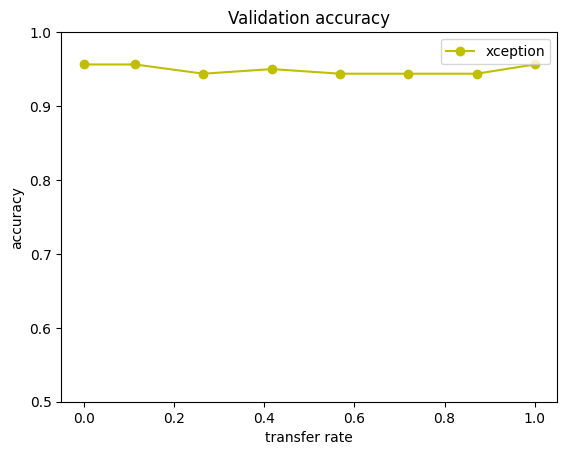

In [8]:
#展示结果

import matplotlib.pyplot as plt
plt.figure()
plt.plot(r_list,r_acc,linestyle='-',marker='o',color='y',label='xception')
plt.xlabel('transfer rate')
plt.ylabel('accuracy')
plt.ylim((0.5,1))

plt.title('Validation accuracy')
plt.legend()
plt.show()


In [9]:
#在unlabel(test)数据集上测试

base_dir = pathlib.Path('chest_xray2')
test_dataset = tf.keras.utils.image_dataset_from_directory(base_dir/'unlabel',
                                                            image_size=(224,224),
                                                            batch_size=32)
test_images,test_labels = preprocess_data(test_dataset)

Found 1000 files belonging to 2 classes.


In [10]:
model_0 = tf.keras.models.load_model('xception_r_0.00.keras')
model_1 = tf.keras.models.load_model('xception_r_0.11.keras')
model_2 = tf.keras.models.load_model('xception_r_0.27.keras')
model_3 = tf.keras.models.load_model('xception_r_0.42.keras')
model_4 = tf.keras.models.load_model('xception_r_0.57.keras')
model_5 = tf.keras.models.load_model('xception_r_0.72.keras')
model_6 = tf.keras.models.load_model('xception_r_0.87.keras')
model_7 = tf.keras.models.load_model('xception_r_1.00.keras')

In [11]:
r_acc_t = []
test_loss,test_acc = model_0.evaluate(test_images,test_labels)
print(test_acc)
r_acc_t.append(test_acc)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32/32 [==============================] - 56s 2s/step - loss: 0.3082 - accuracy: 0.8670
0.8669999837875366


In [12]:
test_loss,test_acc = model_1.evaluate(test_images,test_labels)
print(test_acc)
r_acc_t.append(test_acc)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32/32 [==============================] - 50s 2s/step - loss: 0.3007 - accuracy: 0.8730
0.8730000257492065


In [13]:
test_loss,test_acc = model_2.evaluate(test_images,test_labels)
print(test_acc)
r_acc_t.append(test_acc)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32/32 [==============================] - 51s 2s/step - loss: 0.3304 - accuracy: 0.8510
0.8510000109672546


In [14]:
test_loss,test_acc = model_3.evaluate(test_images,test_labels)
print(test_acc)
r_acc_t.append(test_acc)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32/32 [==============================] - 52s 2s/step - loss: 0.3126 - accuracy: 0.8630
0.8629999756813049


In [15]:
test_loss,test_acc = model_4.evaluate(test_images,test_labels)
print(test_acc)
r_acc_t.append(test_acc)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32/32 [==============================] - 50s 2s/step - loss: 0.3240 - accuracy: 0.8550
0.8550000190734863


In [16]:
test_loss,test_acc = model_5.evaluate(test_images,test_labels)
print(test_acc)
r_acc_t.append(test_acc)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32/32 [==============================] - 50s 2s/step - loss: 0.3233 - accuracy: 0.8550
0.8550000190734863


In [17]:
test_loss,test_acc = model_6.evaluate(test_images,test_labels)
print(test_acc)
r_acc_t.append(test_acc)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32/32 [==============================] - 49s 2s/step - loss: 0.3233 - accuracy: 0.8540
0.8539999723434448


In [18]:
test_loss,test_acc = model_7.evaluate(test_images,test_labels)
print(test_acc)
r_acc_t.append(test_acc)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32/32 [==============================] - 50s 2s/step - loss: 0.3342 - accuracy: 0.8500
0.8500000238418579


In [19]:
print(r_acc_t)

[0.8669999837875366, 0.8730000257492065, 0.8510000109672546, 0.8629999756813049, 0.8550000190734863, 0.8550000190734863, 0.8539999723434448, 0.8500000238418579]


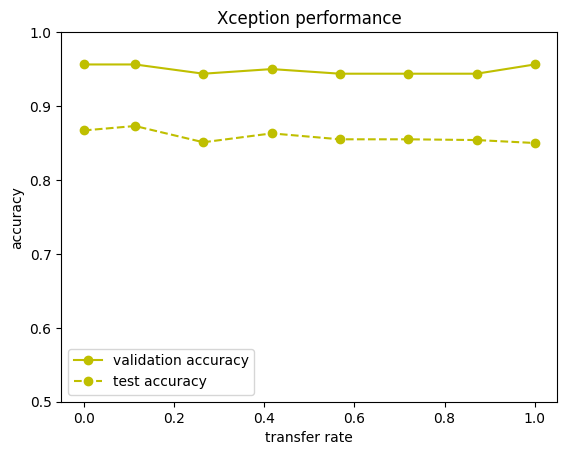

In [20]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(r_list,r_acc,linestyle='-',marker='o',color='y',label='validation accuracy')
plt.plot(r_list,r_acc_t,linestyle='--',marker='o',color='y',label='test accuracy')
plt.xlabel('transfer rate')
plt.ylabel('accuracy')
plt.ylim((0.5,1))

plt.title('Xception performance')
plt.legend()
plt.show()

In [21]:
#在unlabel(test)数据集上测试聚类
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

In [22]:
feature = tf.keras.layers.GlobalAveragePooling2D()(model_0.get_layer('block14_sepconv2_act').output)
encoder_0 = tf.keras.Model(inputs=model_0.input,outputs=feature)
X = encoder_0.predict(test_images)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [24]:
kmeans = KMeans(n_clusters=2, n_init=20)
y_pred = kmeans.fit_predict(X)
acc = accuracy_score(test_labels,y_pred)
print(acc)

0.718


In [25]:
feature = tf.keras.layers.GlobalAveragePooling2D()(model_1.get_layer('block14_sepconv2_act').output)
encoder_1 = tf.keras.Model(inputs=model_1.input,outputs=feature)
X = encoder_1.predict(test_images)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [27]:
kmeans = KMeans(n_clusters=2, n_init=20)
y_pred = kmeans.fit_predict(X)
acc = accuracy_score(test_labels,y_pred)
print(acc)

0.723


In [28]:
feature = tf.keras.layers.GlobalAveragePooling2D()(model_2.get_layer('block14_sepconv2_act').output)
encoder_2 = tf.keras.Model(inputs=model_2.input,outputs=feature)
X = encoder_2.predict(test_images)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [31]:
kmeans = KMeans(n_clusters=2, n_init=20)
y_pred = kmeans.fit_predict(X)
acc = accuracy_score(test_labels,y_pred)
print(acc)

0.7


In [32]:
feature = tf.keras.layers.GlobalAveragePooling2D()(model_3.get_layer('block14_sepconv2_act').output)
encoder_3 = tf.keras.Model(inputs=model_3.input,outputs=feature)
X = encoder_3.predict(test_images)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [34]:
kmeans = KMeans(n_clusters=2, n_init=20)
y_pred = kmeans.fit_predict(X)
acc = accuracy_score(test_labels,y_pred)
print(acc)

0.705


In [35]:
feature = tf.keras.layers.GlobalAveragePooling2D()(model_4.get_layer('block14_sepconv2_act').output)
encoder_4 = tf.keras.Model(inputs=model_4.input,outputs=feature)
X = encoder_4.predict(test_images)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [36]:
kmeans = KMeans(n_clusters=2, n_init=20)
y_pred = kmeans.fit_predict(X)
acc = accuracy_score(test_labels,y_pred)
print(acc)

0.699


In [37]:
feature = tf.keras.layers.GlobalAveragePooling2D()(model_5.get_layer('block14_sepconv2_act').output)
encoder_5 = tf.keras.Model(inputs=model_5.input,outputs=feature)
X = encoder_5.predict(test_images)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [39]:
kmeans = KMeans(n_clusters=2, n_init=20)
y_pred = kmeans.fit_predict(X)
acc = accuracy_score(test_labels,y_pred)
print(acc)

0.699


In [40]:
feature = tf.keras.layers.GlobalAveragePooling2D()(model_6.get_layer('block14_sepconv2_act').output)
encoder_6 = tf.keras.Model(inputs=model_6.input,outputs=feature)
X = encoder_6.predict(test_images)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [43]:
kmeans = KMeans(n_clusters=2, n_init=20)
y_pred = kmeans.fit_predict(X)
acc = accuracy_score(test_labels,y_pred)
print(acc)

0.699


In [44]:
feature = tf.keras.layers.GlobalAveragePooling2D()(model_7.get_layer('block14_sepconv2_act').output)
encoder_7 = tf.keras.Model(inputs=model_7.input,outputs=feature)
X = encoder_7.predict(test_images)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [45]:
kmeans = KMeans(n_clusters=2, n_init=20)
y_pred = kmeans.fit_predict(X)
acc = accuracy_score(test_labels,y_pred)
print(acc)

0.699


In [46]:
r_acc_k = [0.718,0.723,0.7,0.705,0.699,0.699,0.699,0.699]
print(r_acc_k)

[0.718, 0.723, 0.7, 0.705, 0.699, 0.699, 0.699, 0.699]


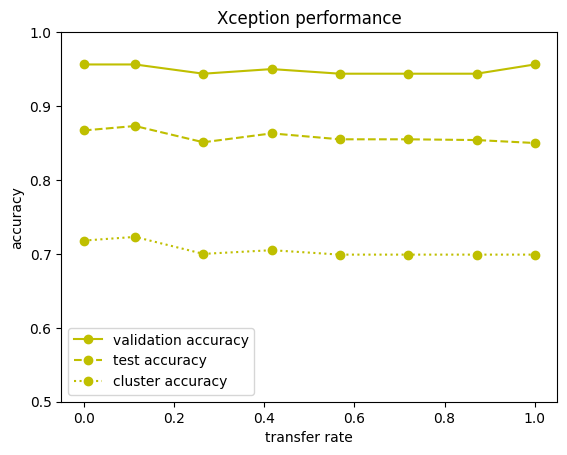

In [47]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(r_list,r_acc,linestyle='-',marker='o',color='y',label='validation accuracy')
plt.plot(r_list,r_acc_t,linestyle='--',marker='o',color='y',label='test accuracy')
plt.plot(r_list,r_acc_k,linestyle=':',marker='o',color='y',label='cluster accuracy')
plt.xlabel('transfer rate')
plt.ylabel('accuracy')
plt.ylim((0.5,1))

plt.title('Xception performance')
plt.legend()
plt.show()